# 🏋️  Exercise
Let's collect the stuff together and shoot at the target!

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error
from itertools import product

In [69]:
# Using skip rows because we have used the `names` paramer to rename to "sales"

df = pd.read_csv("../data/perrin-freres-monthly-champagne.csv", 
                index_col=0,
                parse_dates=True,
                names=["Sales"],
                skiprows=1, # skip rows will skip the header being read as data.
                skipfooter=2, # skip footer will skip the last 2 rows as they contain NaN
                engine='python')

df.index.freq = "MS"

In [70]:
df.head()

,Sales
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [71]:
df.shape

(105, 1)

Good.

###### 

So, now... *just forget* about what we did in the notebooks before. Like, did the manual sutff and so on. They were **absolutely** correct and to-the-point but here... if you start thinking about them then it will be a mess. 

**Here**, we are only gonna use the built-in method. Which will make the stuff much smoother and streamlined. Let's start with the data `viz`!

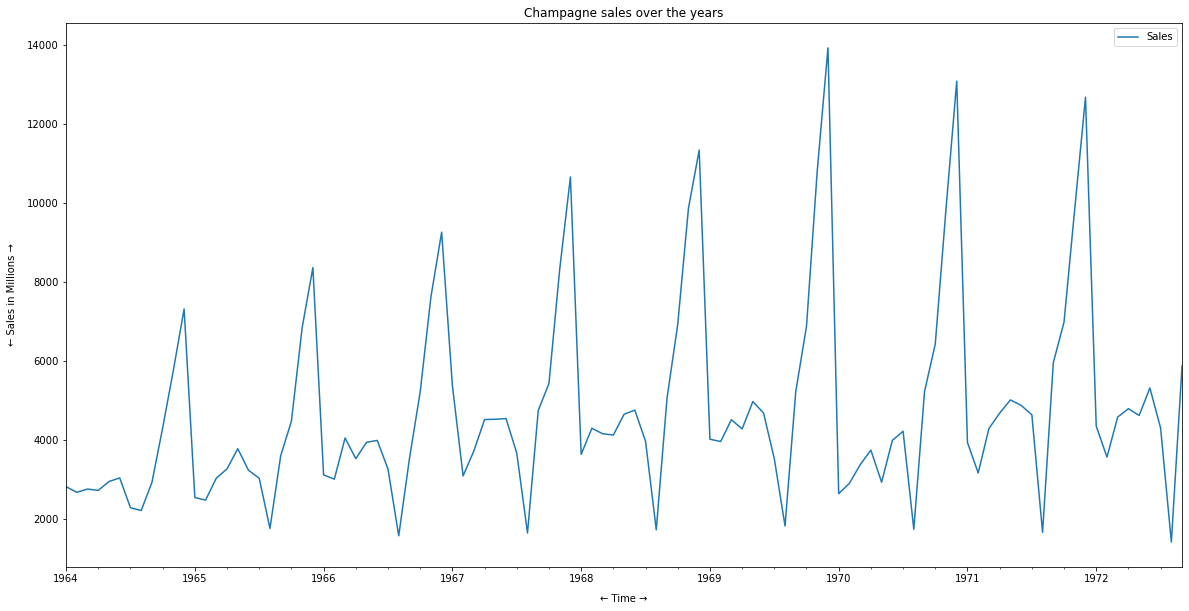

In [72]:
df.plot()
plt.title("Champagne sales over the years")
plt.xlabel("← Time →", labelpad=10)
plt.ylabel("← Sales in Millions →", labelpad=10);

Clearly it is a strong suggestion of a seasonal data. There are **regular** spikes in some month per year.
- It is observed that the sales kept increasing over the years till 1969 having a stopn **peak**
- After 1970, it looks it is falling.
- **It will be interesting** to see how it behaves after 1972 in our forecast period.

—

Again, I will be using the ***GridSearch*** here to find the best possible parameters for the testing. Once I am happy with that... I will use those settings to train it on **whole dataset** and then will forecast in the future. 

Since, this data is showing the pattern in the **yearly** setting, I will be keeping it `12` as the period.

In [84]:
h = 12
offset = 1
def walkforward(
    trend_type,
    season_type,
    init_method,
    use_boxcox,
    debug=False):
    
    """
    This function should be called either individually or from the 
    grid search (the manual one).
    
    What is does is, it will fit and validate the model sotring the 
    errors of each fold in the errors list.
    
    Returns the mean of errors.
    """
    errors = []
    for th, idx in enumerate(range(70, len(df) + 1 - h, offset)):
        # Two simple parts
        train = df.iloc[:idx]
        test = df.iloc[idx:idx+h]
        
        # The model initialization of the parameters 
        model = ExponentialSmoothing(train, 
                                    trend=trend_type,
                                    seasonal=season_type,
                                    initialization_method=init_method,
                                    use_boxcox=use_boxcox,
                                    seasonal_periods=12)
        # Learning
        result = model.fit()
        
        # Getting the forecast results
        forecast = result.forecast(h)
        
        # Storing the error
        error = mean_absolute_percentage_error(test, forecast)
        errors.append(error)
        
    if debug:
        print("Total", th + 1, "steps!")
            
    return np.mean(errors) * 100

In [85]:
walkforward("add", "mul", "estimated", True, True)

Total 24 steps!


17.285805330097705

So, this simple version does `17%` error in the data. Let's get things running for the GridSearch.

### Defining the list of the parameters

In [86]:
list_of_parameters = \
[
    ["add", "mul"],
    ["add", "mul"],
    ["estimated", "heuristic", "legacy-heuristic"],
    [True, False]
]

In [87]:
# Total possible combinations
2 * 2 * 3 * 2

24

In [88]:
def gridSearch(list_of_parameters):
    best_score = float('inf') # NEW!
    best_hyperparams = None
    
    for th, parameters in enumerate(product(*list_of_parameters)):
        print(th + 1, "/24", sep="")
        score = walkforward(*parameters)
        
        if score < best_score:
            best_score = score
            best_hyperparams = parameters
            
    return best_score, best_hyperparams

In [89]:
best_score, best_hyper = gridSearch(list_of_parameters)

1/24
2/24
3/24
4/24
5/24
6/24
7/24
8/24
9/24
10/24
11/24
12/24
13/24
14/24
15/24
16/24
17/24
18/24
19/24
20/24
21/24
22/24
23/24
24/24


In [90]:
best_score

13.818154891884568

In [91]:
best_hyper

('add', 'mul', 'legacy-heuristic', False)

### Simple Train and Test... see what happens 

In [92]:
train = df.iloc[:-12]
test = df.iloc[-12:]

In [93]:
model = ExponentialSmoothing(train,
                            trend="add",
                            seasonal="mul",
                            initialization_method="legacy-heuristic",
                            use_boxcox=False)

In [94]:
result = model.fit()

In [96]:
forecast = result.forecast(12)
forecast = pd.Series(forecast, index=test.index)

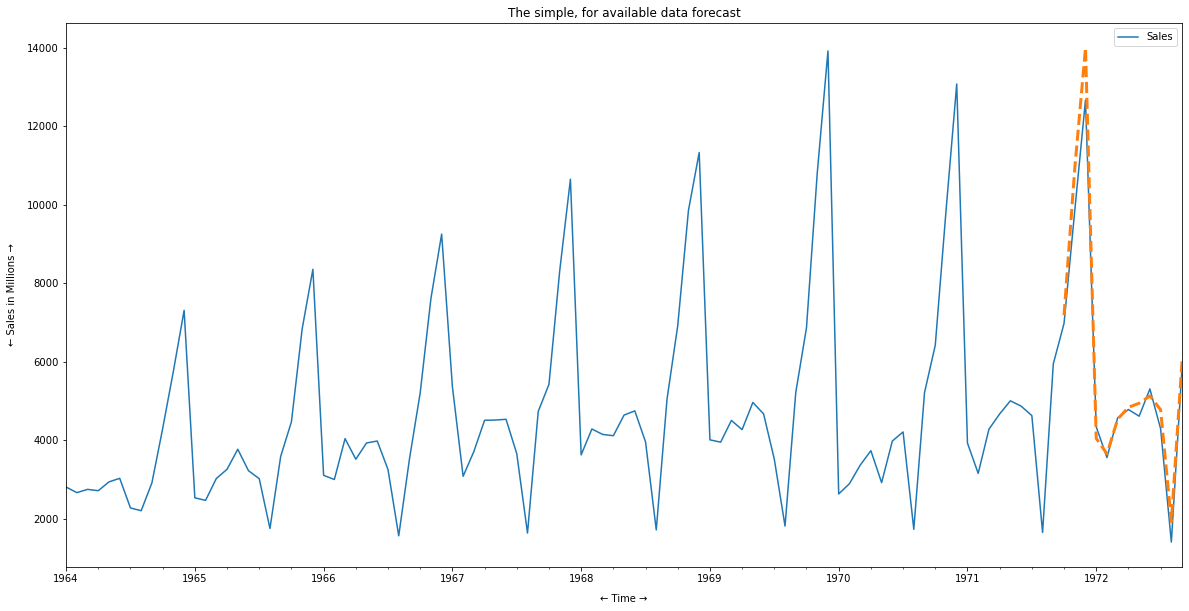

In [104]:
df.plot()
forecast.plot(ls="--", lw=3)
plt.title("The simple, for available data forecast")
plt.xlabel("← Time →", labelpad=10)
plt.ylabel("← Sales in Millions →", labelpad=10);

##### 

### 📈 A Real Forecast

In [111]:
model = ExponentialSmoothing(df,
                            trend="add",
                            seasonal="mul",
                            initialization_method="legacy-heuristic",
                            use_boxcox=False)

result = model.fit()

In [127]:
forecast = result.forecast(24)

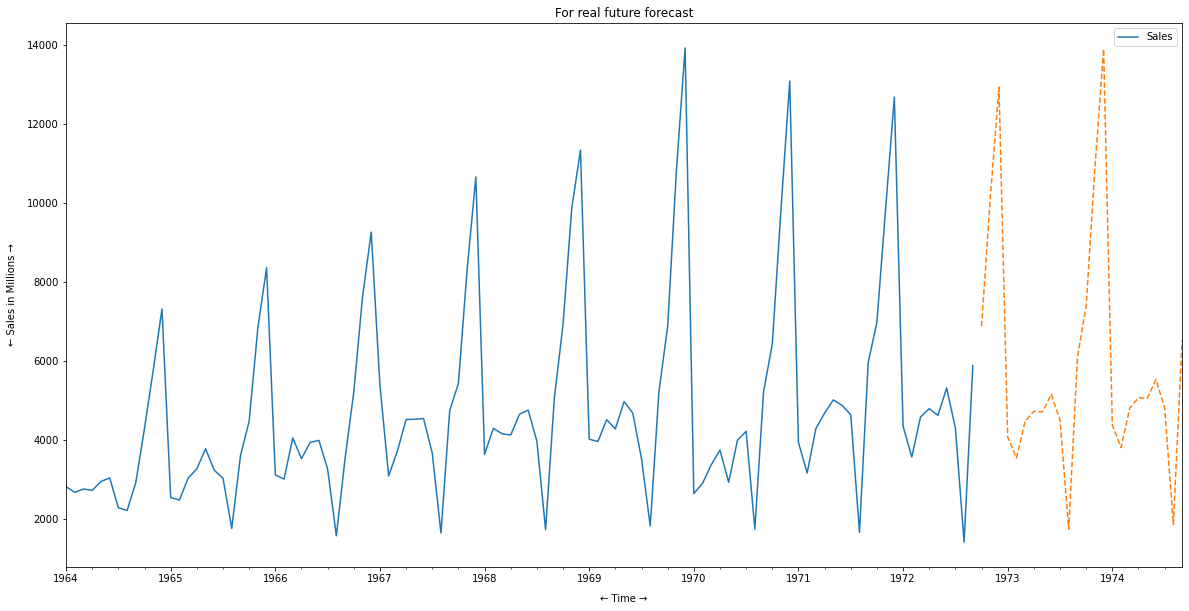

In [128]:
df.plot()
forecast.plot(ls="--")
plt.title("For real future forecast")
plt.xlabel("← Time →", labelpad=10)
plt.ylabel("← Sales in Millions →", labelpad=10);

Only for `2` years ahead. **LOOKS FASCINATING!** Let's go for more!

In [133]:
forecast = result.forecast(120) # 10 years

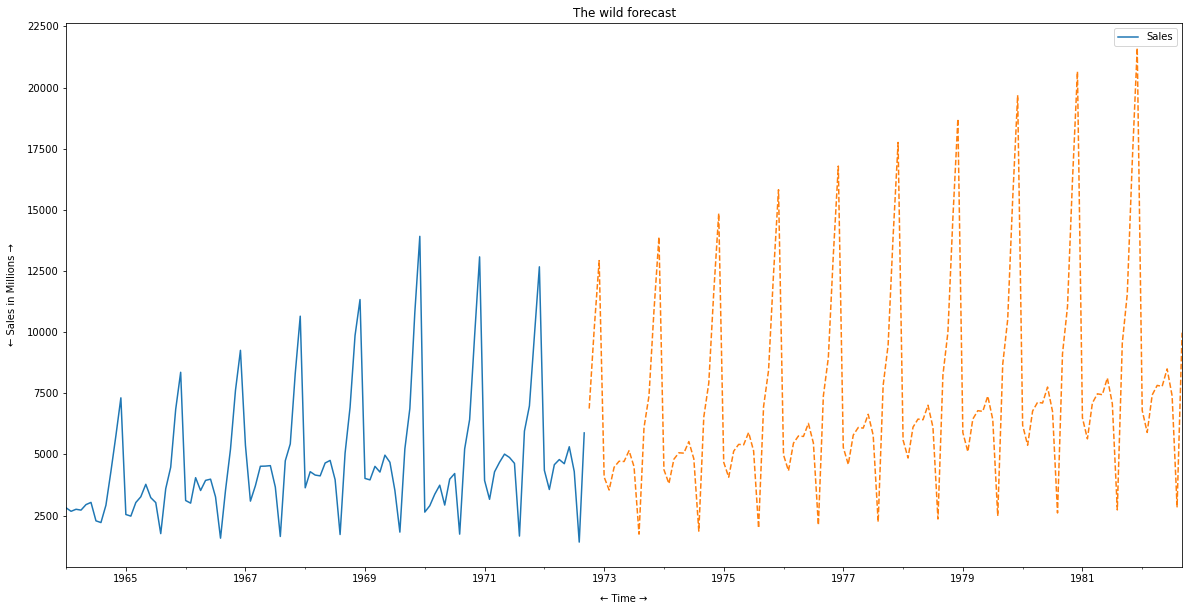

In [135]:
df.plot()
forecast.plot(ls="--")
plt.title("The wild forecast")
plt.xlabel("← Time →", labelpad=10)
plt.ylabel("← Sales in Millions →", labelpad=10);

Bruh! It is increasing... let's try `add` as season!

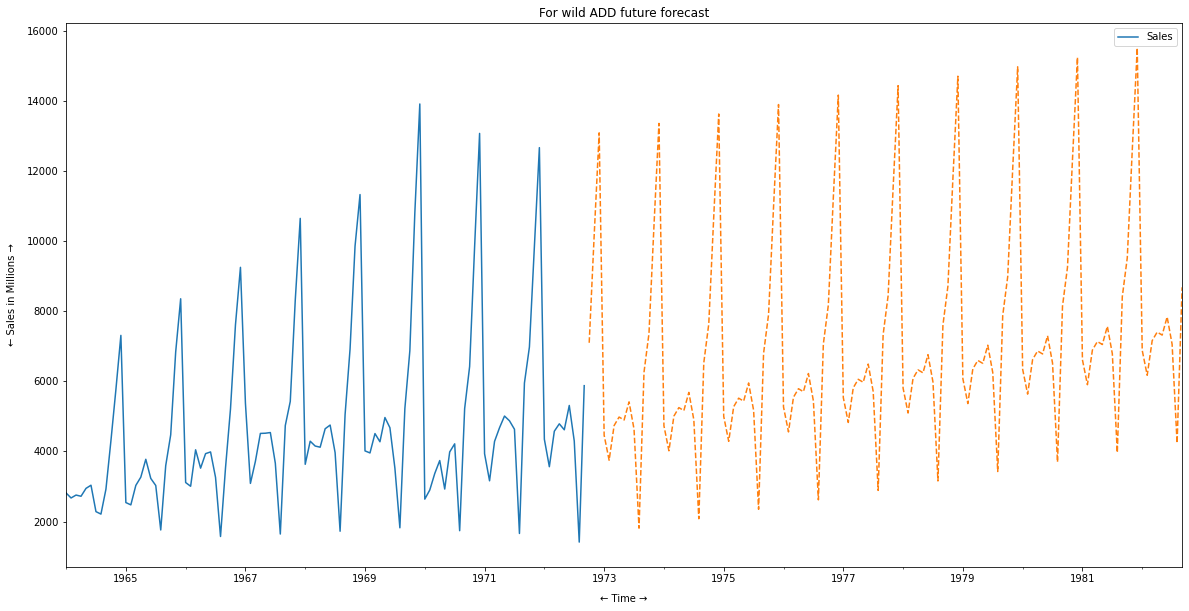

In [144]:
model = ExponentialSmoothing(df,
                            trend="add",
                            seasonal="add",
                            initialization_method="legacy-heuristic",
                            use_boxcox=False)

result = model.fit()
forecast = result.forecast(120)

df.plot()
forecast.plot(ls="--")
plt.title("For wild ADD future forecast")
plt.xlabel("← Time →", labelpad=10)
plt.ylabel("← Sales in Millions →", labelpad=10);

Alright, the settings received by the GridSearch looks **better**!

# 